# Yolo图像加载预处理
- YoloV5的训练的图像加载，流程如下，主要使用了马赛克增广(mosaic)：
    - 1.指定图像大小，例如640，注意没有指定宽高，仅仅是img_size = 640
    - 2.使用马赛克加载图像load_mosaic(self, index)
        - a.在所有dataset中选择4个图像（index，以及3个随机选择的图）
        - b.加载4个图像，并等比将图像长边缩放到img_size
        - c.创建一个大图，尺寸是2 * img_size, 2 * img_size，填充为全114、类型是uint8，3通道
        - c.将4个图像按照马赛克的方式拼接在一起放到大图上，例如指定随机uniform(img_size // 2, 2 * img_size - img_size // 2)中心为center，那么img1的右下角在center，img2的左下角在center，img3的右上角在center，img4的左上角在center
        - d.将4个图像的labels拼接为一个矩阵后，数值xywh变为left, top, right, bottom，并根据图像的位移，修改labels的位置
        - e.裁切超出区域的值，限制到（0, 2 * img_size）
        - f.此时得到输出，img为大图（2 * img_size, 2 * img_size），和labels（left, top, right, bottom）
        ```Python
        def load_mosaic(self, index):
            # loads images in a mosaic

            labels4 = []
            s = self.img_size
            yc, xc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]  # mosaic center x, y
            indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
            for i, index in enumerate(indices):
                # Load image
                img, _, (h, w) = load_image(self, index)

                # place img in img4
                if i == 0:  # top left
                    img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                    x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                    x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
                elif i == 1:  # top right
                    x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                    x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
                elif i == 2:  # bottom left
                    x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                    x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
                elif i == 3:  # bottom right
                    x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                    x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

                img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
                padw = x1a - x1b
                padh = y1a - y1b

                # Labels
                x = self.labels[index]
                labels = x.copy()
                if x.size > 0:  # Normalized xywh to pixel xyxy format
                    labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
                    labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
                    labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
                    labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
                labels4.append(labels)

            # Concat/clip labels
            if len(labels4):
                labels4 = np.concatenate(labels4, 0)
                # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
                np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine
        ```
    - 3.random_affine，scale指定为0.5，这里translate和shear、degrees并没有使用
        - a.对大图进行随机变换，输出图像大小为img_size、img_size的目标大小
        - b.使用getRotationMatrix2D获取变换矩阵，中心为大图的中心，scale则是uniform(1 - scale, 1 + scale)
        - c.使用获取的变换矩阵对图像进行变换，并对框进行变换得到结果框
        - d.裁切坐标和宽高的大小，保证在图像内
        - e.根据条件保留box：
            - 第一条件：box的宽高大于2  (w > 2) & (h > 2)
            - 第二条件：box裁切后面积和box裁切前面积比 > 0.2
            - 第三条件：box的宽高比，高宽比最大值 < 20
        ```Python
        def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=(0, 0)):
            # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
            # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4
            # targets = [cls, xyxy]

            height = img.shape[0] + border[0] * 2  # shape(h,w,c)
            width = img.shape[1] + border[1] * 2

            # Rotation and Scale
            R = np.eye(3)
            a = random.uniform(-degrees, degrees)
            # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
            s = random.uniform(1 - scale, 1 + scale)
            # s = 2 ** random.uniform(-scale, scale)
            R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

            # Translation
            T = np.eye(3)
            T[0, 2] = random.uniform(-translate, translate) * img.shape[1] + border[1]  # x translation (pixels)
            T[1, 2] = random.uniform(-translate, translate) * img.shape[0] + border[0]  # y translation (pixels)

            # Shear
            S = np.eye(3)
            S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
            S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

            # Combined rotation matrix
            M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
            if (border[0] != 0) or (border[1] != 0) or (M != np.eye(3)).any():  # image changed
                img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

            # Transform label coordinates
            n = len(targets)
            if n:
                # warp points
                xy = np.ones((n * 4, 3))
                xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
                xy = (xy @ M.T)[:, :2].reshape(n, 8)

                # create new boxes
                x = xy[:, [0, 2, 4, 6]]
                y = xy[:, [1, 3, 5, 7]]
                xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

                # # apply angle-based reduction of bounding boxes
                # radians = a * math.pi / 180
                # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
                # x = (xy[:, 2] + xy[:, 0]) / 2
                # y = (xy[:, 3] + xy[:, 1]) / 2
                # w = (xy[:, 2] - xy[:, 0]) * reduction
                # h = (xy[:, 3] - xy[:, 1]) * reduction
                # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

                # reject warped points outside of image
                xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
                xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
                w = xy[:, 2] - xy[:, 0]
                h = xy[:, 3] - xy[:, 1]
                area = w * h
                area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
                ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
                i = (w > 2) & (h > 2) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 20)

                targets = targets[i]
                targets[:, 1:5] = xy[i]

            return img, targets
        ```
    - 4.augment_hsv，随机hsv颜色变换，系数是：hsv_h: 0.015，hsv_s: 0.7，hsv_v: 0.4
        - a.生成随机增益：r = uniform(-1, 1, 3) * [hsv_h, hsv_s, hsv_v] + 1
        - b.将图像变换为HSV格式后，对h s v三个通道分别进行增益(使用LUT)，然后转换为BGR得到结果
        ```Python
        def augment_hsv(img, hgain=0.5, sgain=0.5, vgain=0.5):
            r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
            hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
            dtype = img.dtype  # uint8

            x = np.arange(0, 256, dtype=np.int16)
            lut_hue = ((x * r[0]) % 180).astype(dtype)
            lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
            lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

            img_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val))).astype(dtype)
            cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR, dst=img)  # no return needed
        ```
    - 5.随机翻转，水平方向随机0.5概率进行翻转。同时翻转labels
    

* YoloV5测试mAP时的图像处理：
    - 1.加载图像，并将长边缩放到img_size大小，load_image(self, index)
    - 2.letterbox(img, shape, auto=False, scaleup=self.augment)，居中缩放，使其大小为img_size, img_size。并将labels修改到同样位置

* YoloV5测试图像，进行检测时的处理：
    - 1.加载图像，并将长边缩放到img_size大小
    - 2.使用自动补齐，即:使得结果图大小能够整除64，不能整除则增加pad区域（填充114）
        - 比如640 x 310的图像，310无法整除64，则通过pad加10个高度，使得尺寸为320，pad方式为上边5、下边5  填充 114

In [33]:
import os
import glob
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

In [15]:
def load_voc_xml(file):
    with open(file, "r") as f:
        data = f.read()
        
    def convert(size, box):
        dw = 1./(size[0])
        dh = 1./(size[1])
        x = (box[0] + box[1])/2.0 - 1
        y = (box[2] + box[3])/2.0 - 1
        w = box[1] - box[0] + 1
        h = box[3] - box[2] + 1
        x = x*dw
        w = w*dw
        y = y*dh
        h = h*dh
        return x, y, w, h

    def middle(s, begin, end, pos_begin = 0):
        p = s.find(begin, pos_begin)
        if p == -1:
            return None, None

        p += len(begin)
        e = s.find(end, p)
        if e == -1:
            return None, None

        return s[p:e], e + len(end)

    objs = []
    object_, pos_ = middle(data, "<object>", "</object>")
    wh_field, _ = middle(data, "<size>", "</size>")
    width = int(middle(wh_field, "<width>", "</width>")[0])
    height = int(middle(wh_field, "<height>", "</height>")[0])
    label_map = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    while object_ is not None:
        xmin = int(middle(object_, "<xmin>", "</xmin>")[0])
        ymin = int(middle(object_, "<ymin>", "</ymin>")[0])
        xmax = int(middle(object_, "<xmax>", "</xmax>")[0])
        ymax = int(middle(object_, "<ymax>", "</ymax>")[0])
        name = middle(object_, "<name>", "</name>")[0]
        object_, pos_ = middle(data, "<object>", "</object>", pos_)
        x, y, w, h = convert((width, height), (xmin, xmax, ymin, ymax))
        label_index = label_map.index(name)
        objs.append((label_index, x, y, w, h))
    return np.array(objs, dtype=np.float32)

In [43]:
image_paths = glob.glob("imgs/*.jpg")
image_annotations = [load_voc_xml(item[:-3] + "xml") for item in images]

# 1.加载图像进行长边缩放

In [20]:
img_size = 640

In [44]:
image = cv2.imread(image_paths[0])
image.shape

(500, 353, 3)

In [45]:
max_line = max(image.shape[:2])
max_line

500

In [46]:
scale = img_size / max_line
scale

1.28

In [47]:
image_resized = cv2.resize(image, (0, 0), fx=scale, fy=scale)
image_resized.shape

(640, 452, 3)

# 2.马赛克增广

In [141]:
img_size = 640
index = 0
x_center, y_center = [int(random.uniform(img_size // 2, 2 * img_size - img_size // 2)) for _ in range(2)]  # mosaic center x, y
#x_center, y_center = [img_size // 2 for _ in range(2)]  # mosaic center x, y
#x_center, y_center = [2 * img_size - img_size // 2 for _ in range(2)]  # mosaic center x, y
x_center, y_center

(821, 519)

In [142]:
indices = [index] + [random.randint(0, len(image_paths) - 1) for _ in range(3)]  # 3 additional image indices
indices

[0, 0, 2, 4]

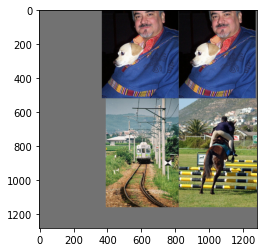

In [144]:
offset_coeff = np.array([[1, 1], [0, 1], [1, 0], [0, 0]])
large_image = np.full((img_size * 2, img_size * 2, 3), 114, dtype=np.uint8)
for pos, image_index in enumerate(indices):
    image = cv2.imread(image_paths[image_index])
    scale = img_size / max(image.shape[:2])
    image = cv2.resize(image, (0, 0), fx=scale, fy=scale)
    image_height, image_width = image.shape[:2]
    
    offset = [x_center, y_center] - axis_coeff[pos] * [image_width, image_height]
    M = np.array([
        [1, 0, offset[0]],
        [0, 1, offset[1]]
    ], dtype=np.float32)
    cv2.warpAffine(image, M, (img_size * 2, img_size * 2), dst=large_image, borderMode=cv2.BORDER_TRANSPARENT)

plt.imshow(large_image[..., ::-1])